In [1]:
import pandas as pd
import numpy as np

In [2]:
# To predict the future give this function the historical data and the date you want to predict
# historical data should end precisely one day before the date you want to predict
# This function will guess today's value as being yesterday's value plus
# some delta
# that delta will be determinte by the current trend and the historical trend
# where "trend" is the slope of the line between today and 7 days ago
# and historical trend what that slope has been over the past few years

def predict(historical_data, date):
    idx = historical_data.shape[0]
    d0 = [] # historical values on this date
    d7 = [] # historical values on this date - 7
    for i in range(idx-365,0,-365):
        ndvi = historical_data.iloc[i]['ndvi_smoothed']
        d0.append(ndvi)
        ndvi = historical_data.iloc[i-7]['ndvi_smoothed']
        d7.append(ndvi)
    
    # what is the ndvi typicaly on this day and this day-7
    typical0 = sum(d0)/len(d0)
    typical7 = sum(d7)/len(d7)

    # what was ndvi yesterday? 
    yesterday = historical_data.iloc[idx-1]['ndvi_smoothed']
    # what was it 7 days ago?
    d7 = historical_data.iloc[idx-7]['ndvi_smoothed']

    # current trend
    slope = (yesterday - d7)/7
    # historically what has the trend been around now
    typical_slope = (typical0 - typical7)/7

    # gyess the change as the average of current trend and historical trend
    # then divide it by 3 instead of 2 to just temper things a bit
    delta = (slope + typical_slope)/3
    
    
    guess = yesterday + delta
    return guess

In [3]:
# get the streambatch NDVI data

file_name = 'data/qa_queries_V28.parquet'
df = pd.read_parquet(file_name)
df = df.sort_values(by=['lat', 'time'])
# slice off all rows where ndvi.streambatch is not nan
sb = df[df['ndvi.streambatch'].notnull()]
# remove all columns except time, lat, ndvi.streambatch
sb = sb[['time', 'lat', 'ndvi.streambatch']]
# sort by lat, time
sb = sb.sort_values(by=['lat', 'time'])
# reset index
sb = sb.reset_index(drop=True)

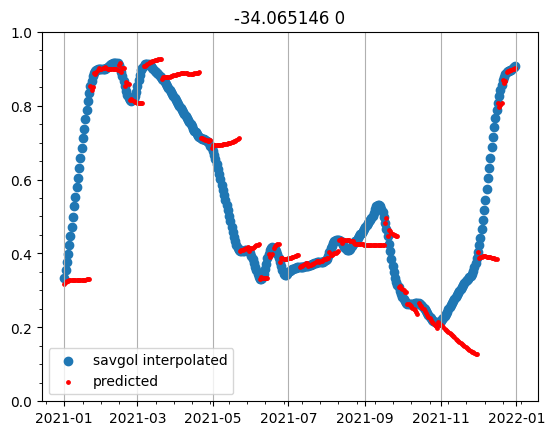

0.11488144673510411


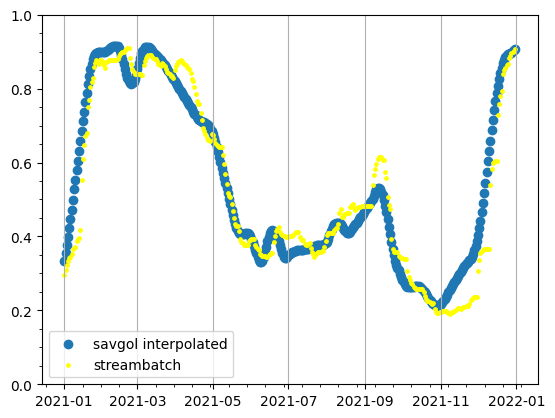

0.06440958404394843


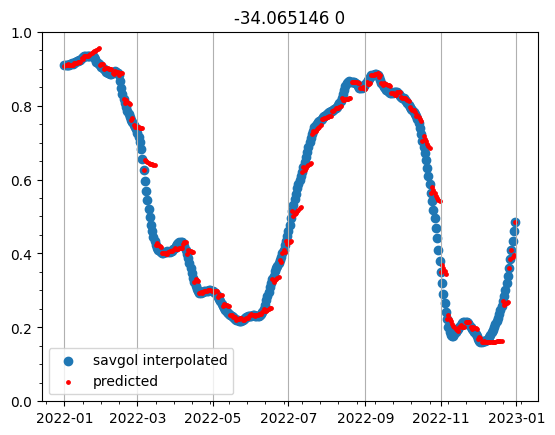

0.037320829715765585


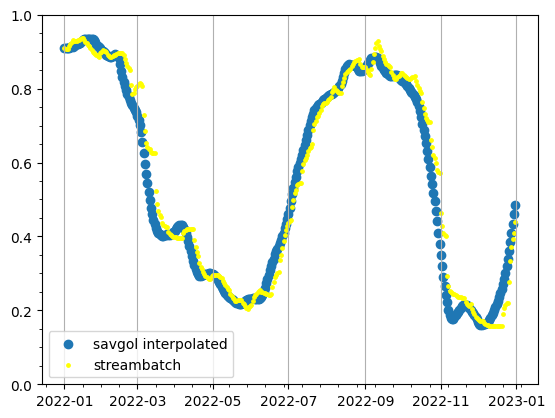

0.051665451859920004


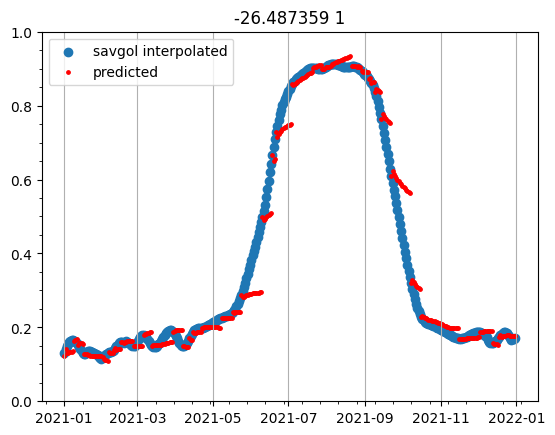

0.04533243030541819


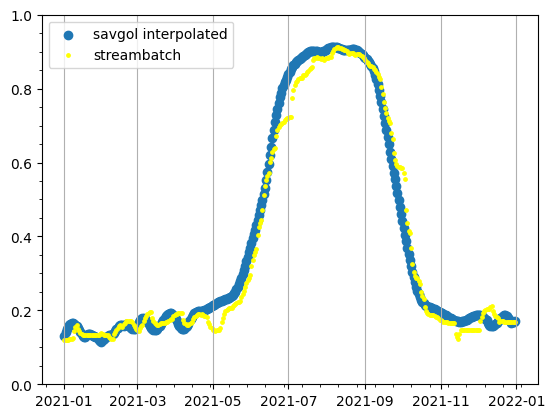

0.03983466631111069


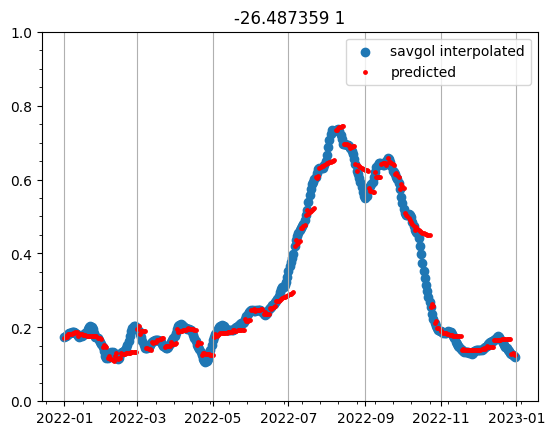

0.03153250431949293


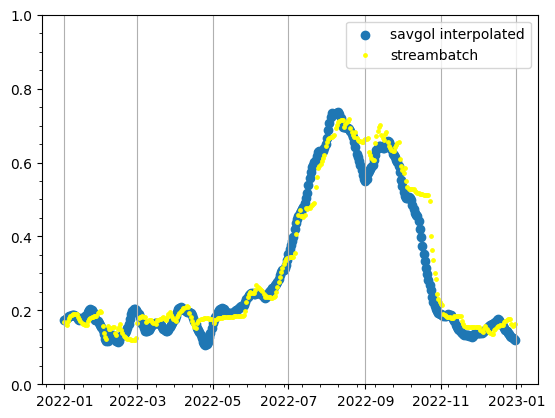

0.04572988030857728


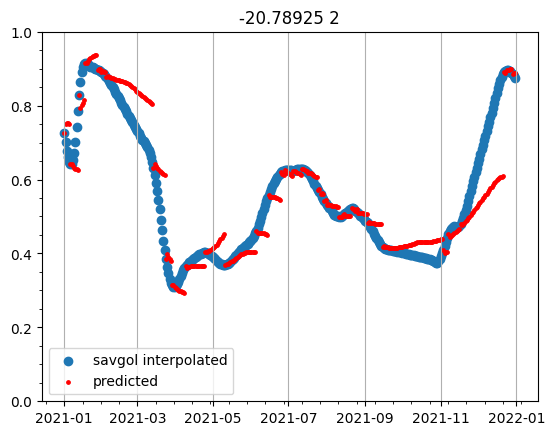

0.06788628819160437


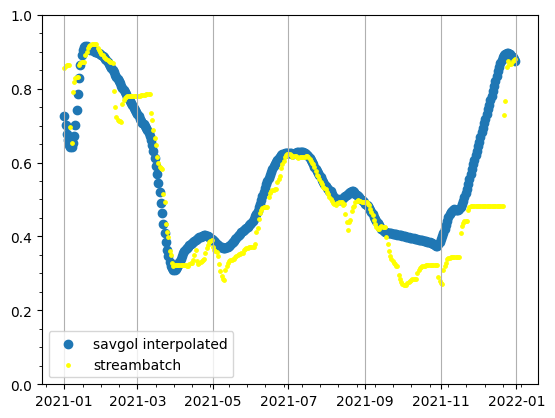

0.09552158823423994


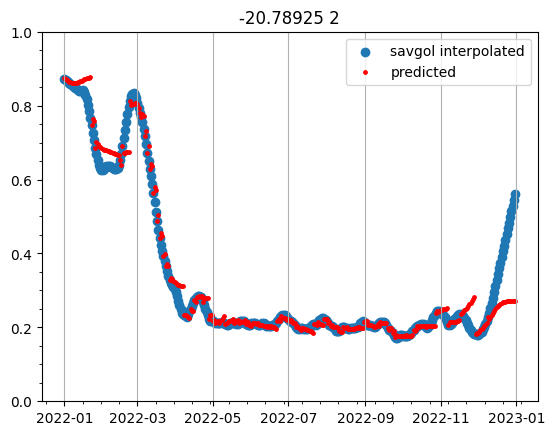

0.04696844865937292


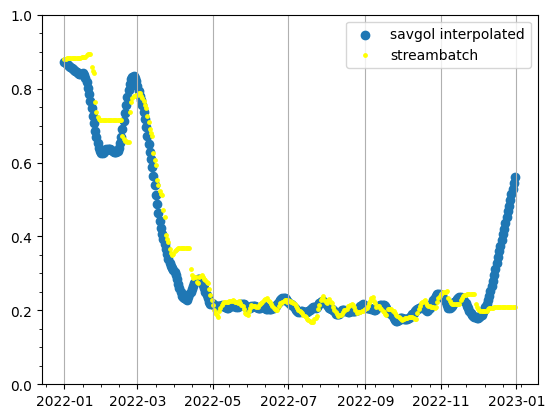

0.06788913208094127


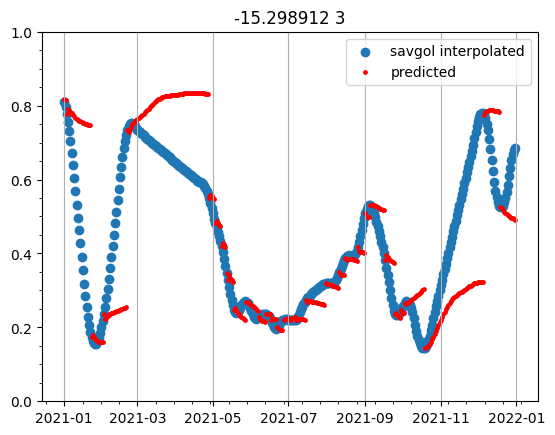

0.16170192706442757


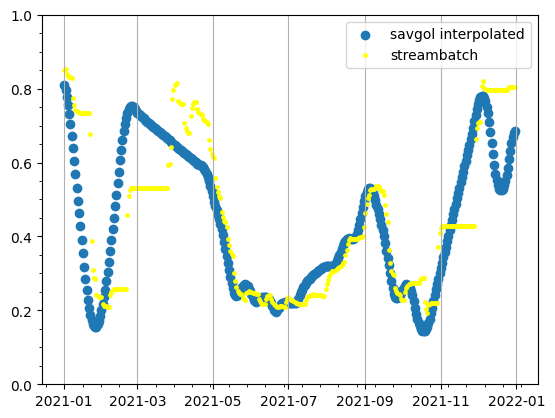

0.14160729060839888


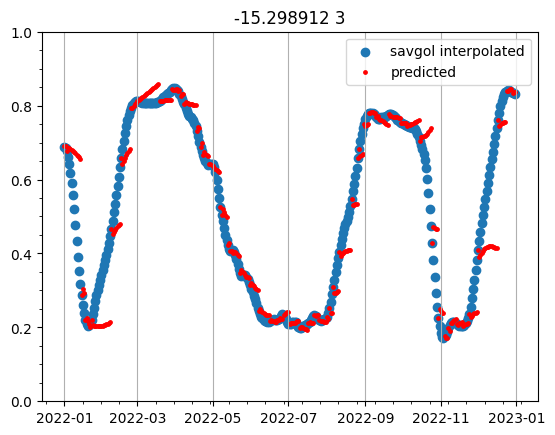

0.07415505527169942


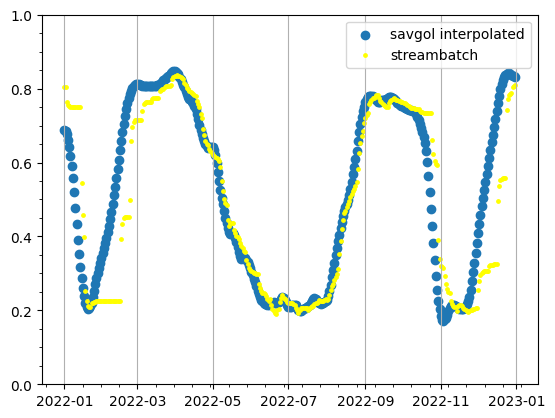

0.12367191354999213


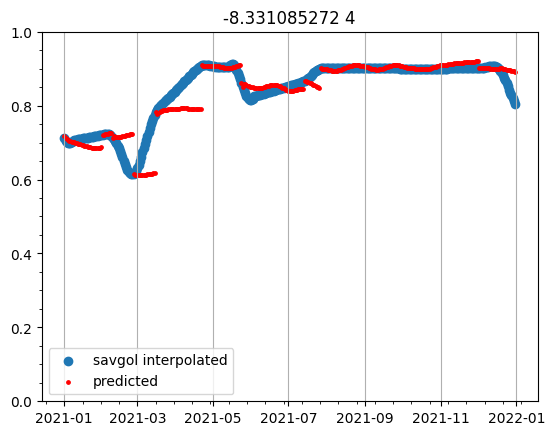

0.036954855369205064


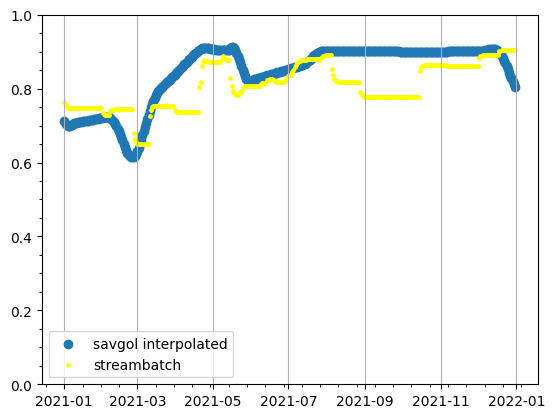

0.07028495355143574


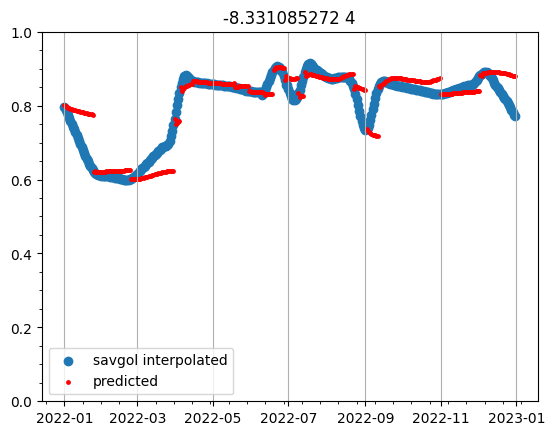

0.04123129996733834


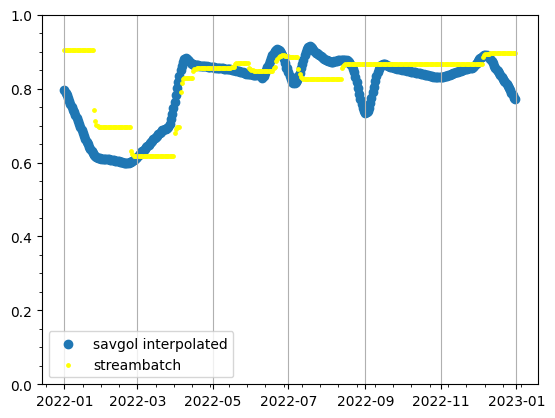

0.07326921139946924


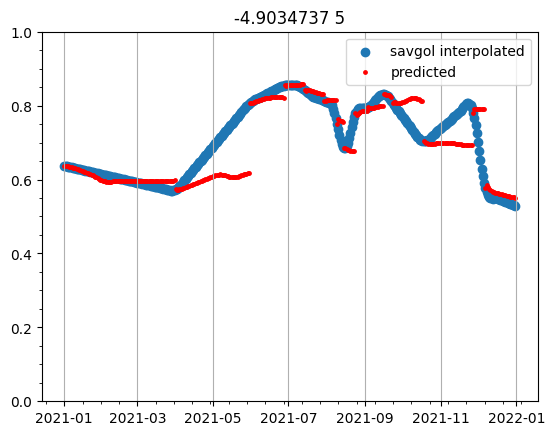

0.0572975133116336


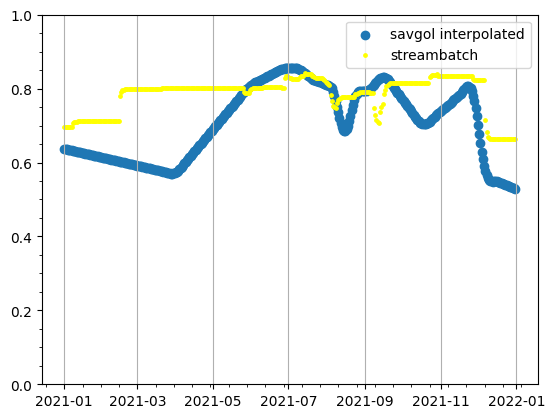

0.11289481128055107


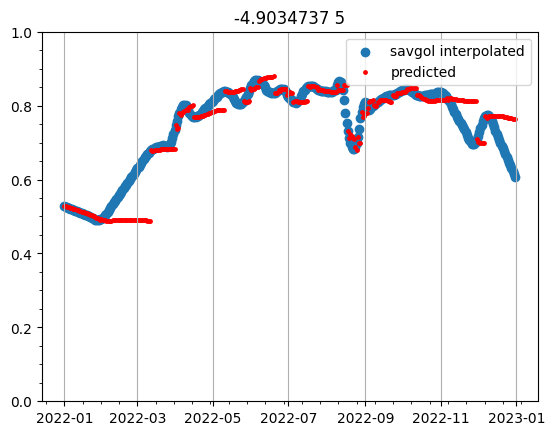

0.050339483349602344


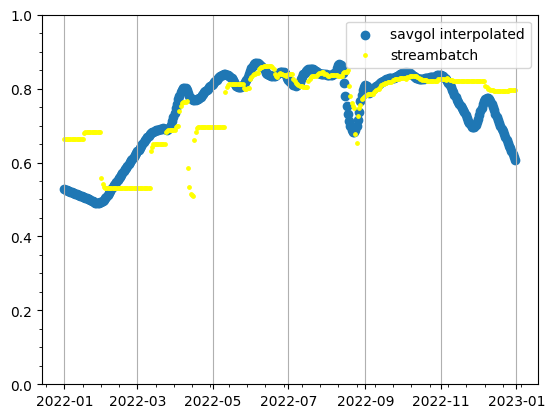

0.08021717458243205


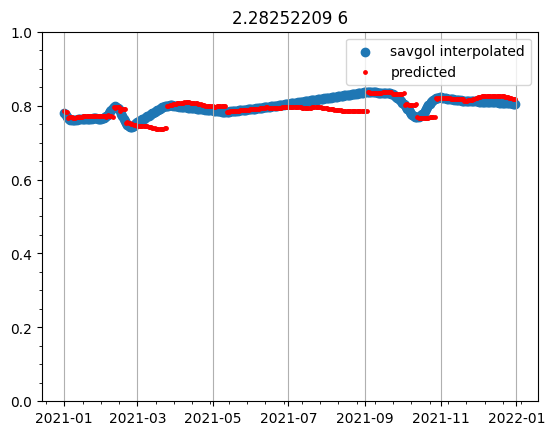

0.0201700775114902


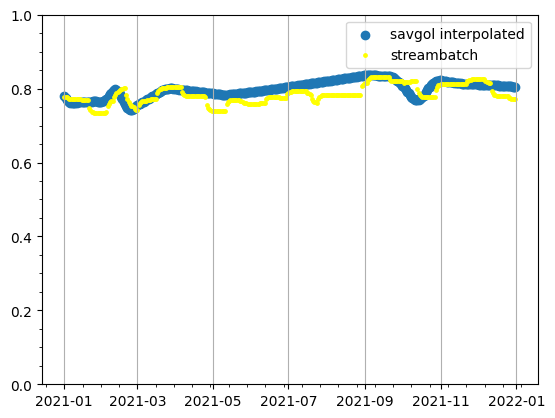

0.024939308576746942


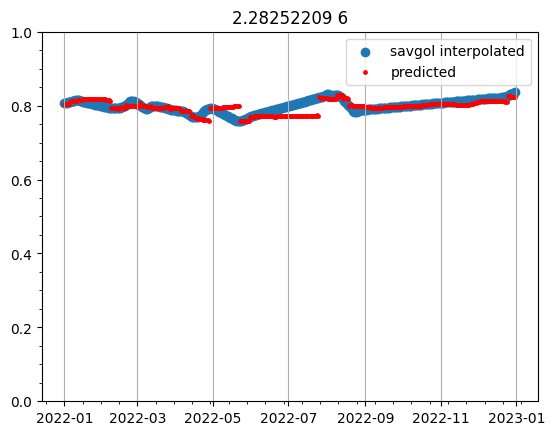

0.01479718485266203


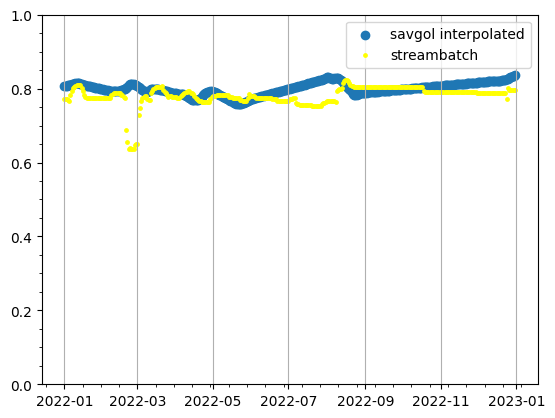

0.03765545781792607


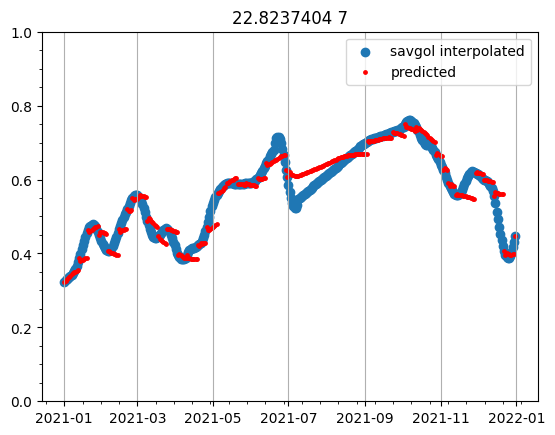

0.031173364284606937


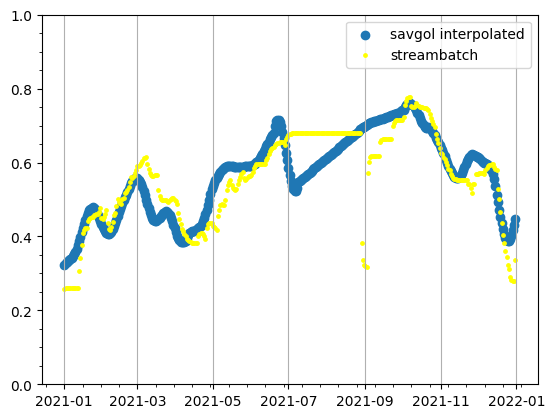

0.07441613286749021


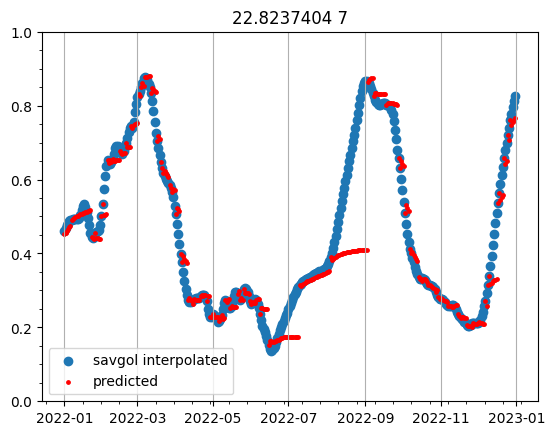

0.08819806459049423


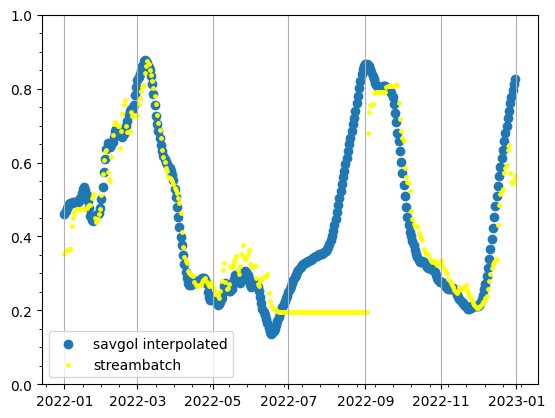

0.15231608995810098


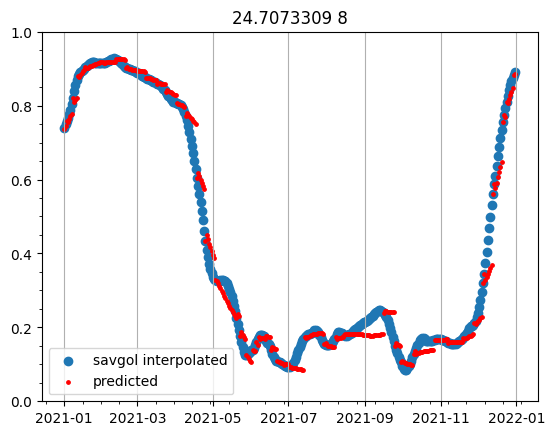

0.03218829678436131


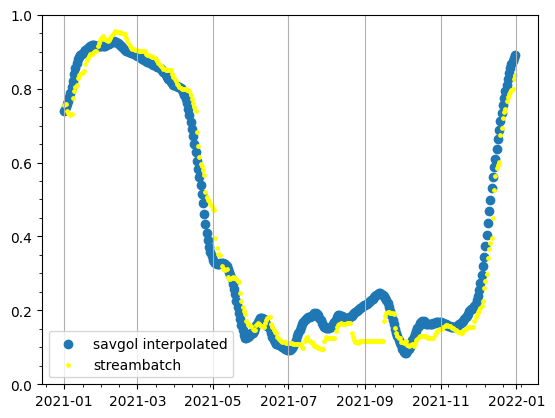

0.05178241424037547


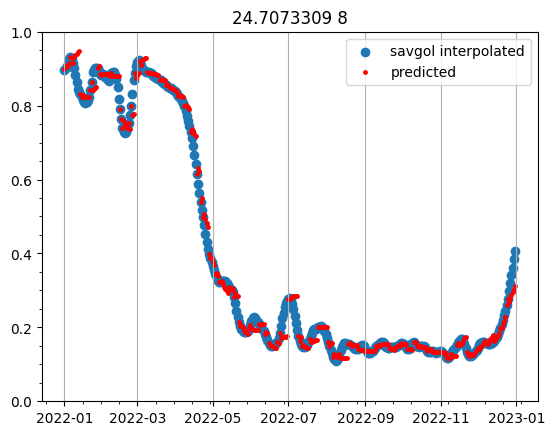

0.02443151332433749


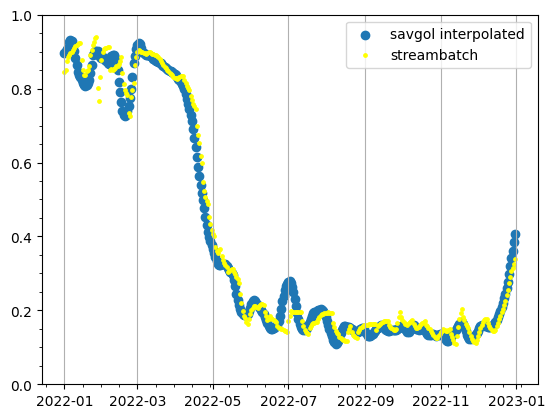

0.03588359084019294


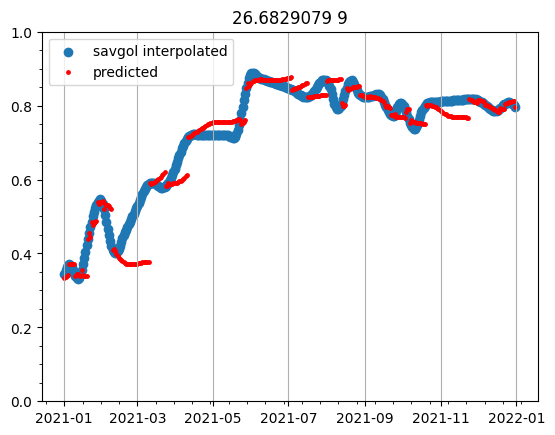

0.04747121080119528


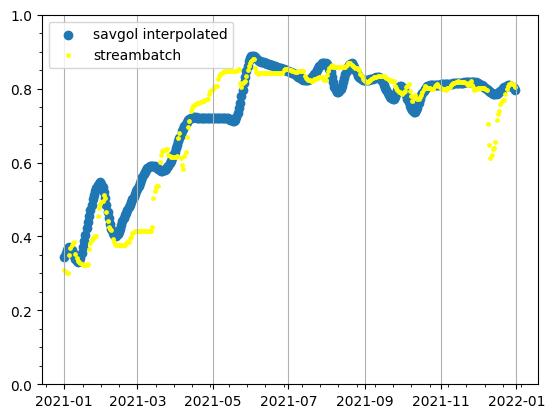

0.058722178803176296


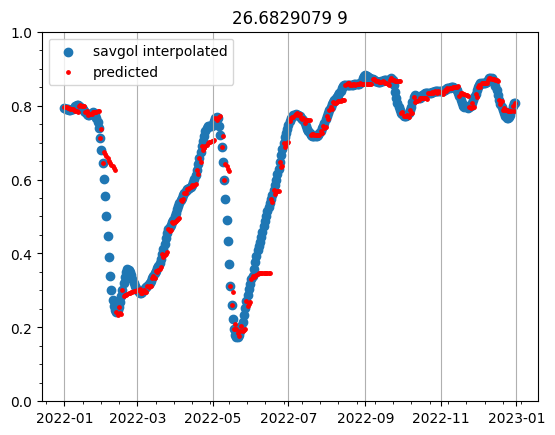

0.05897383494111447


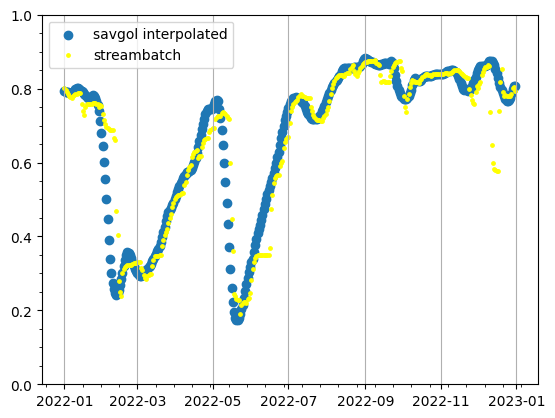

0.08226753809354939


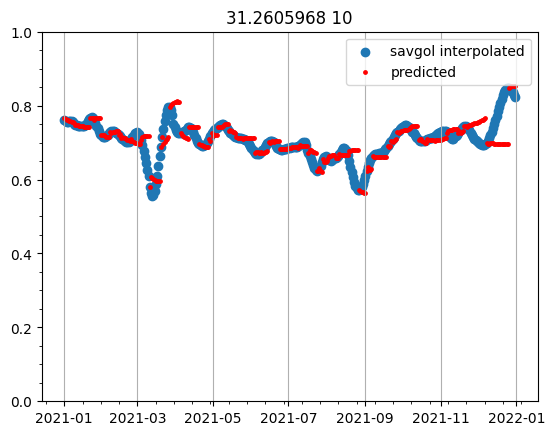

0.03372468762730374


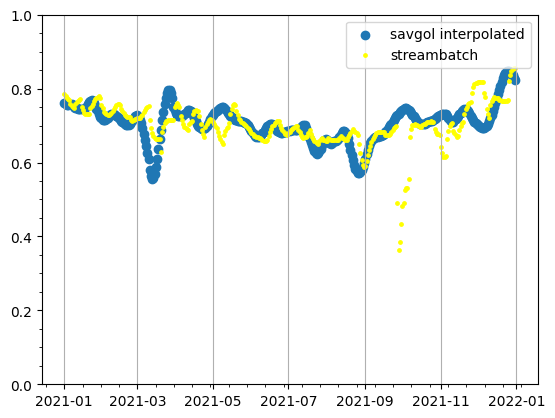

0.0614388540041421


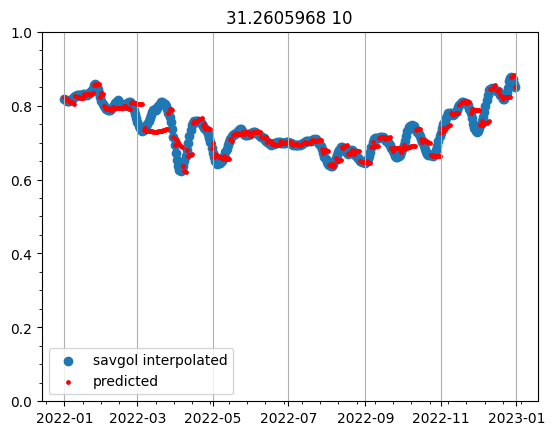

0.02574889365322017


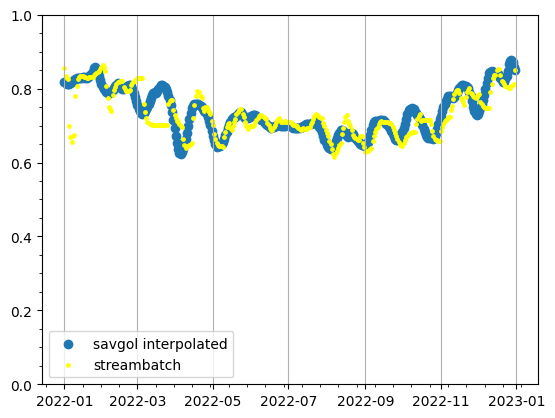

0.040143187557620426


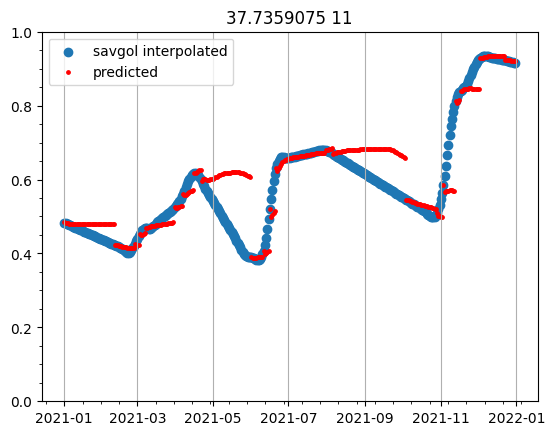

0.06584404876181099


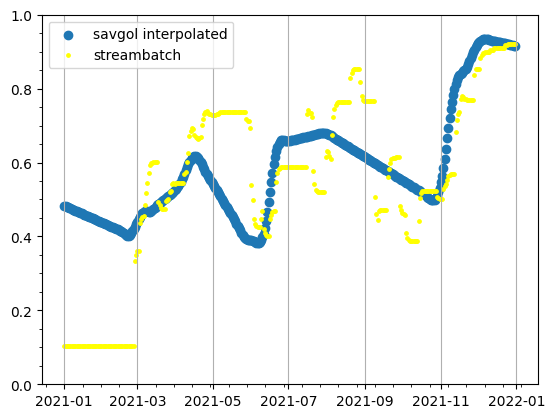

0.17863140832093874


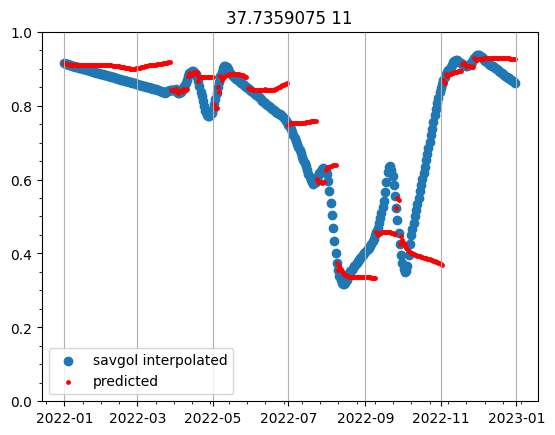

0.09929496757574752


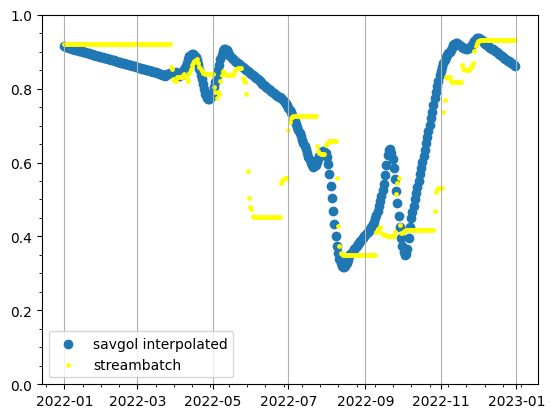

0.13356623862486736


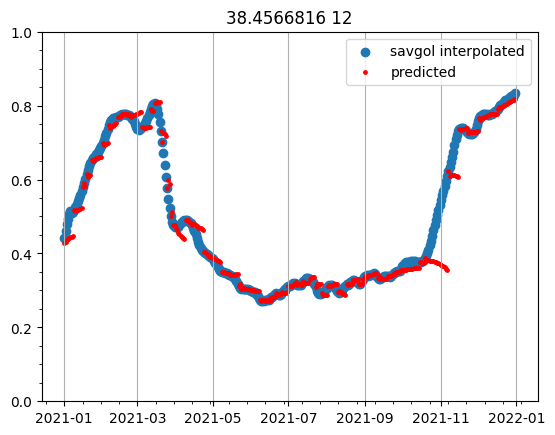

0.03932260281266166


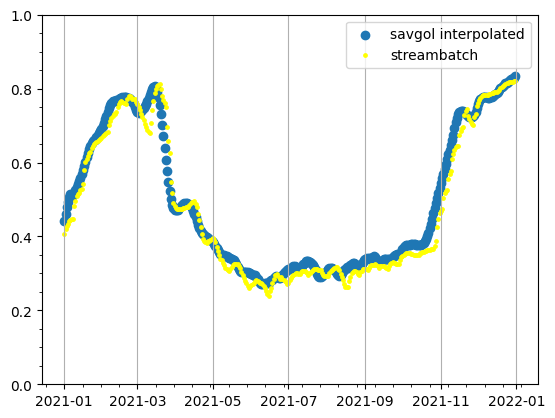

0.035076612570586994


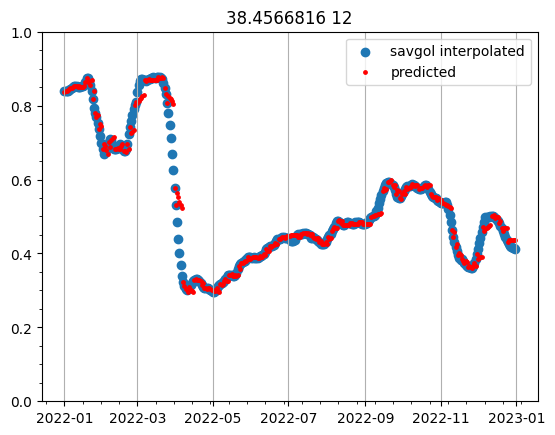

0.02546059352676772


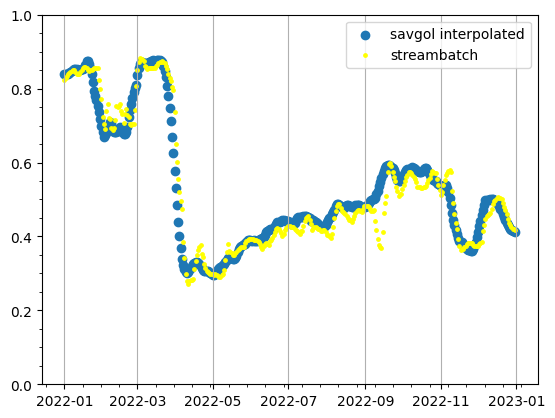

0.04273718328595528


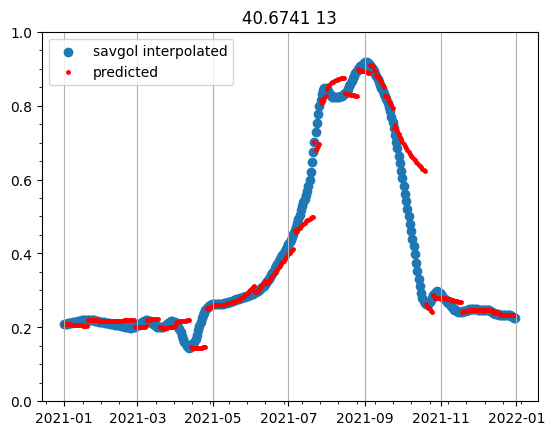

0.06472084148692546


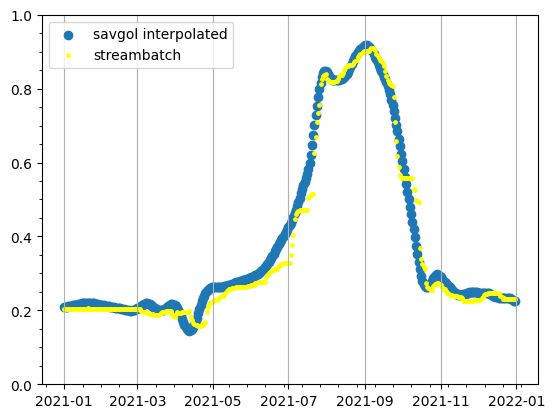

0.037173953724406614


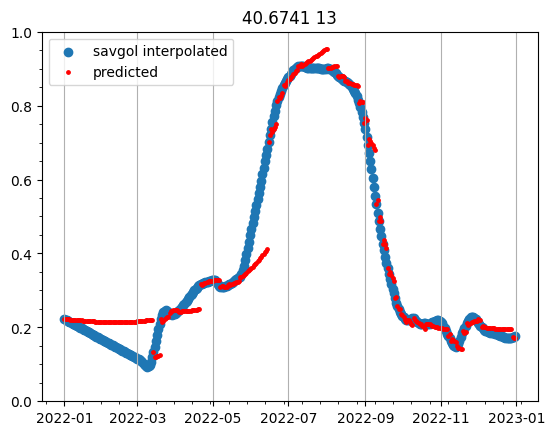

0.05406177177719744


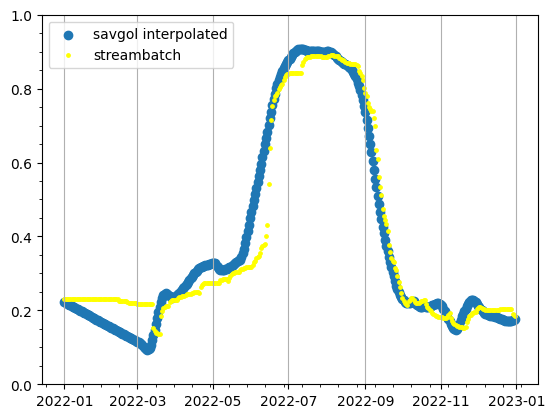

0.06501816340825195


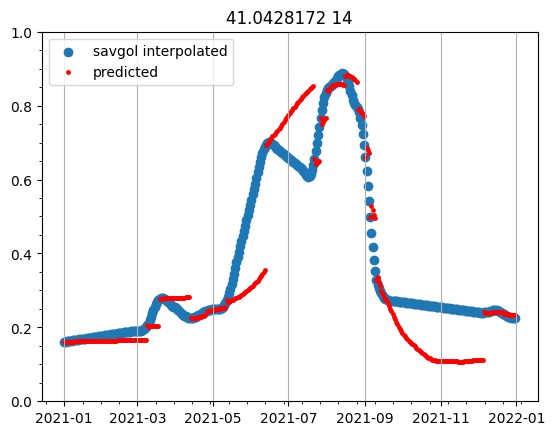

0.09928526238623406


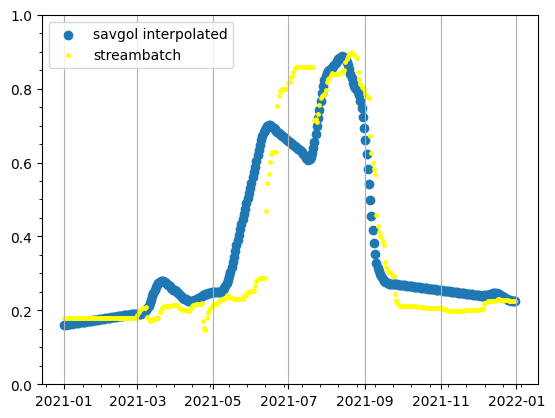

0.10738523549059634


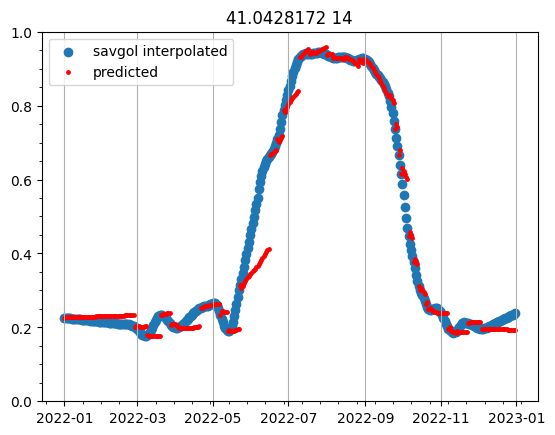

0.04968070676901539


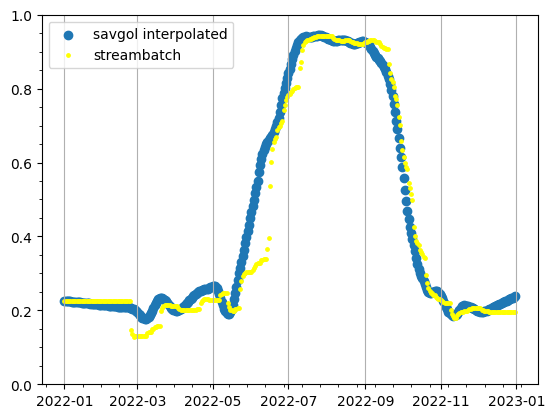

0.06402172686153768


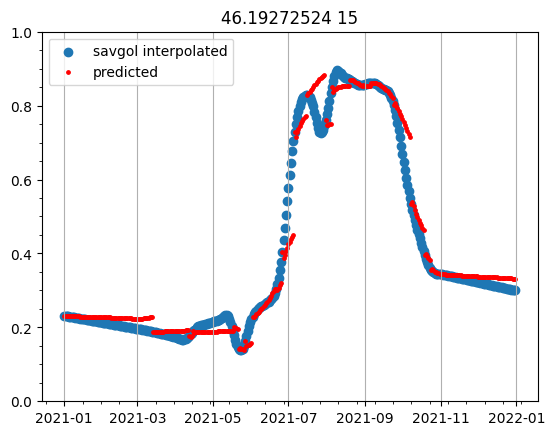

0.04437391662029317


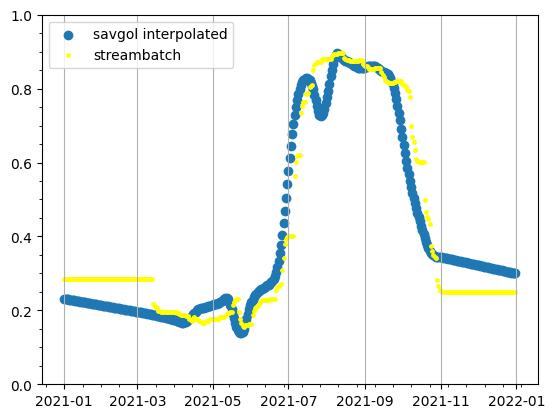

0.07875429053457149


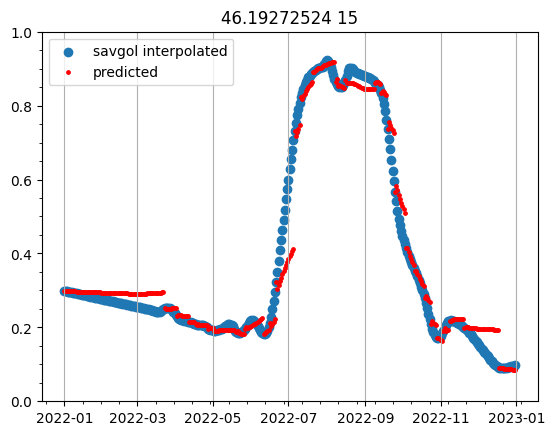

0.047412136925717316


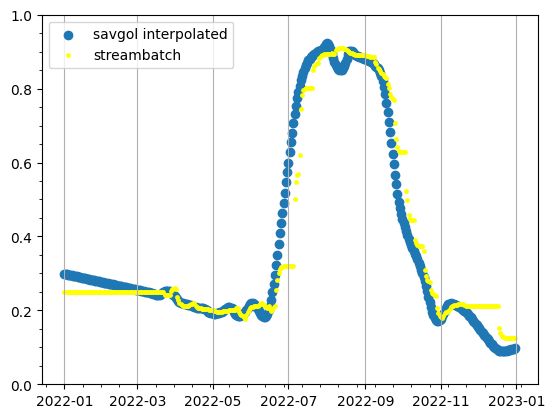

0.07035770863982765


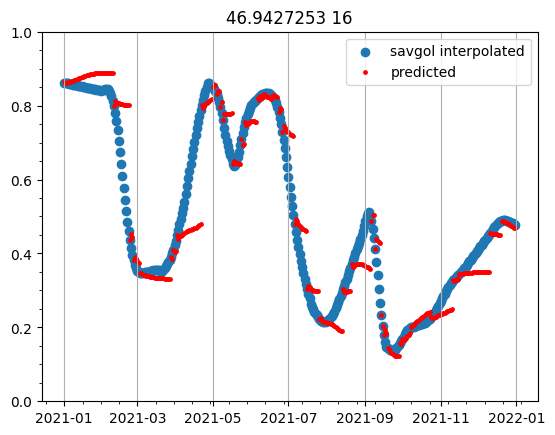

0.07425958345629485


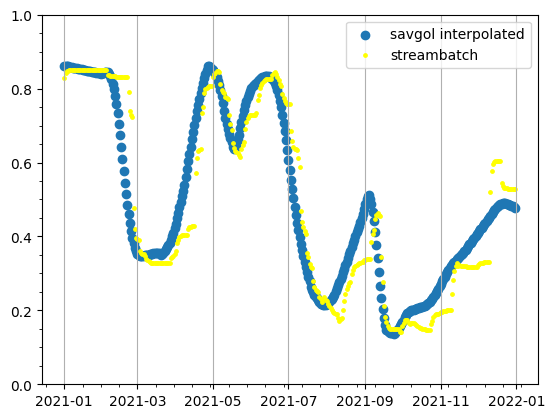

0.09071064053253464


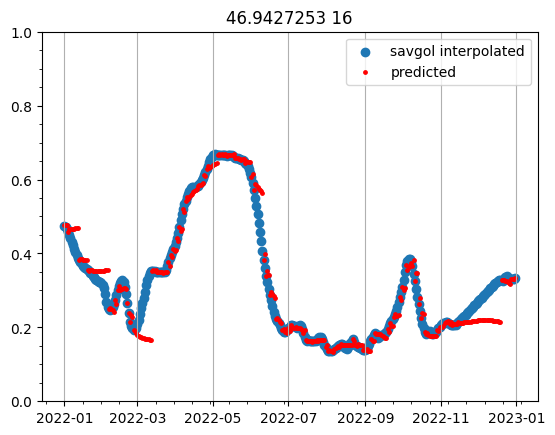

0.0380514180523094


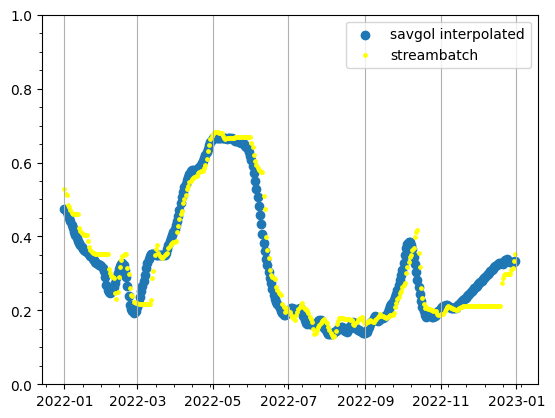

0.043212428529717885


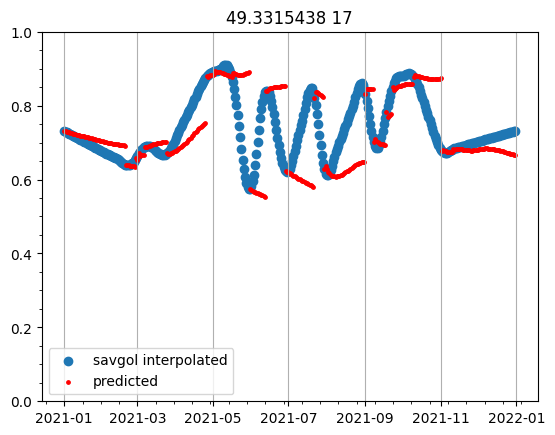

0.0939721045911461


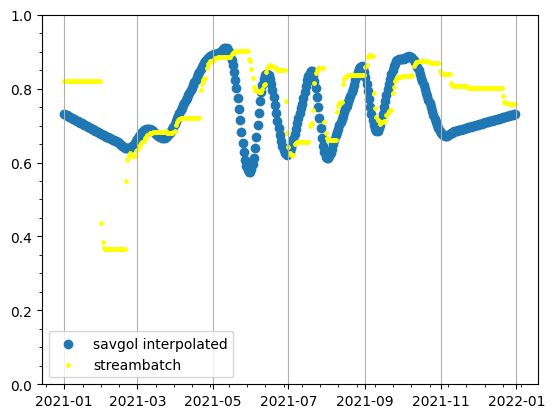

0.11788293616192382


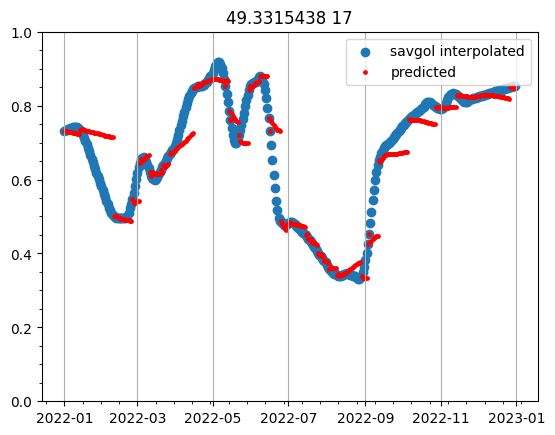

0.05693173793000278


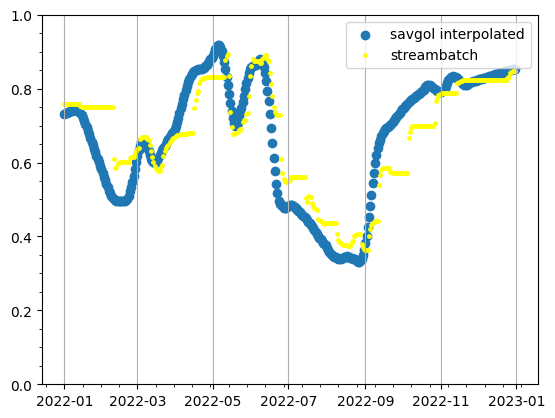

0.08431396230035756


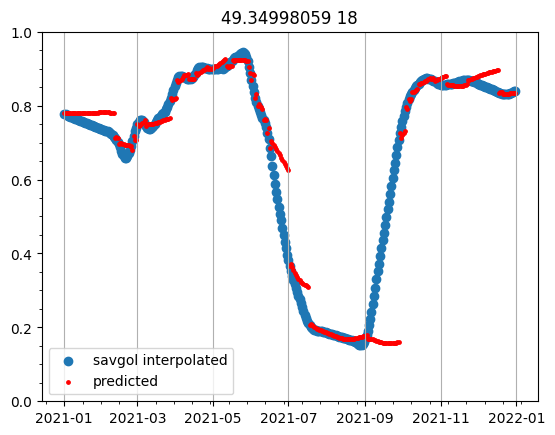

0.09610607683164284


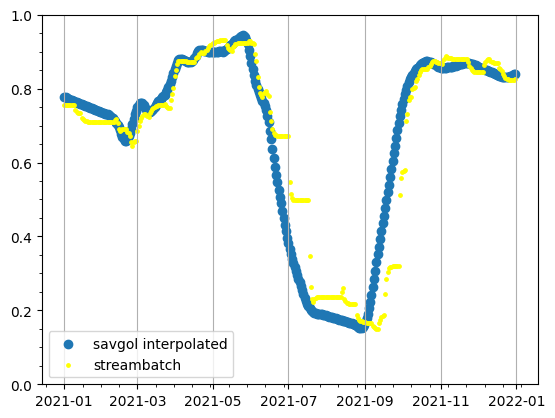

0.09451766794841732


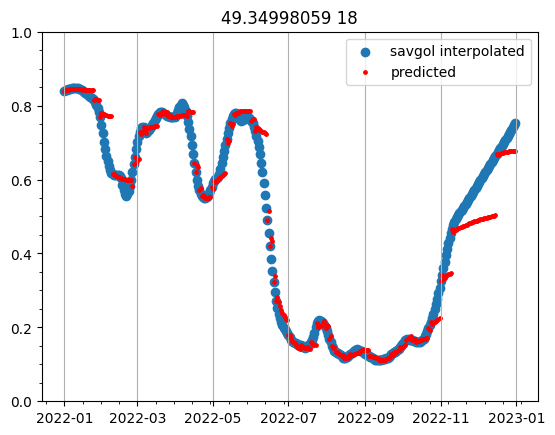

0.045533344357015025


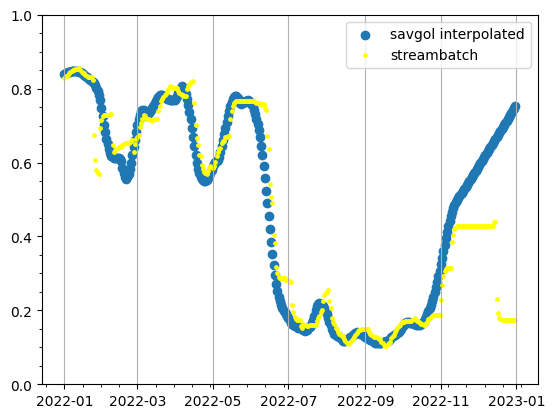

0.13245137555592396


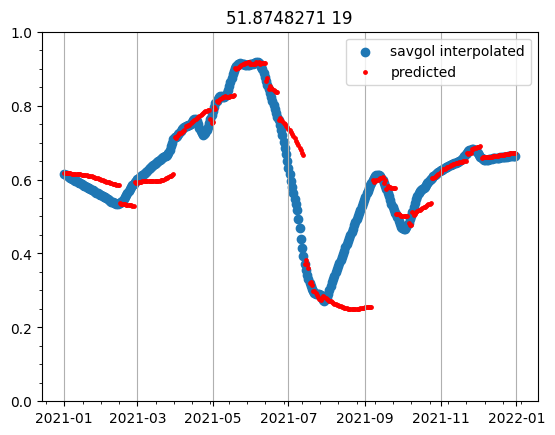

0.08068575612954997


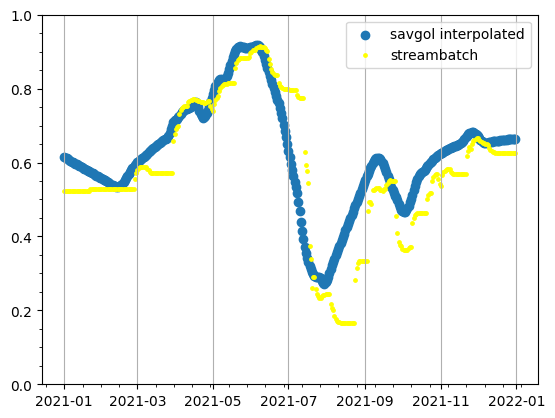

0.1006794191590049


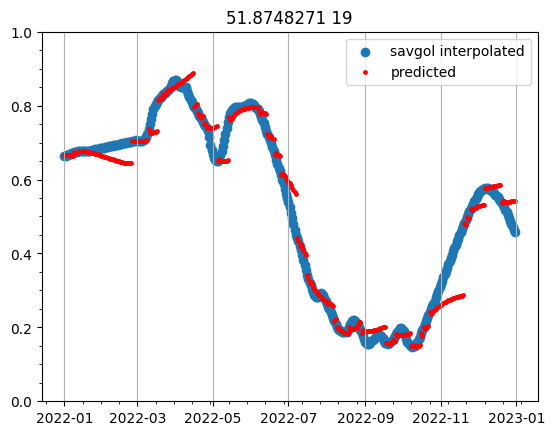

0.04168164644414313


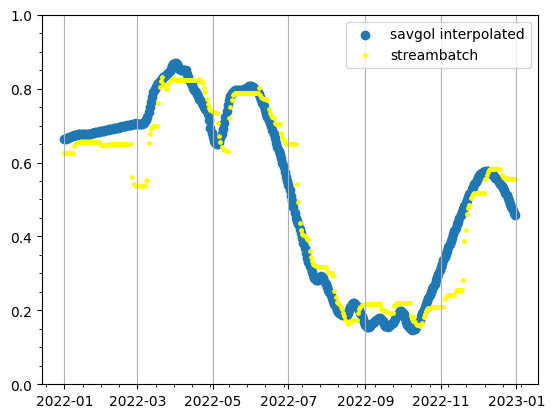

0.06756978276592261
mean rmse: 0.05647894317664812
mean sb_rmse: 0.078265528624642


In [15]:
import matplotlib.pyplot as plt

def make_plot(this,pure1,ds,de,nn):
    this1 = this[ds:de+1]
    # pure1 = pure[(pure['time'] >= start_date) & (pure['time'] <= end_date)]
    plt.title(str(lats[where]) + ' ' + str(where))
    plt.ylim(0, 1.0)
    # plot this['ndvi_smoothed'] and nn['ndvi_smoothed'] with legends vs time
    plt.scatter(this1['time'], this1['ndvi_smoothed'], label='savgol interpolated')
    plt.scatter(nn['time'], nn['ndvi_smoothed'], label='predicted',s=6,color='red')
    # plots s2l8['ndvi'] vs time
    # plt.scatter(pure1['time'], pure1['ndvi'], label='s2l8')
    # add vertical grid lines
    plt.grid(axis='x')
    # add minor vertical grid lines
    plt.minorticks_on()
    plt.legend()
    plt.show()

def plot_sb(this, sb):
    plt.ylim(0, 1.0)
    plt.scatter(this['time'], this['ndvi_smoothed'], label='savgol interpolated')
    plt.scatter(sb['time'], sb['ndvi.streambatch'], label='streambatch',s=6,color='yellow')
    plt.grid(axis='x')
    # add minor vertical grid lines
    plt.minorticks_on()
    plt.legend()
    plt.show()

def extrapolate(pure,this,start_date,end_date):
    ds = this.loc[this['time'] == start_date].index.values[0] 
    de = this.loc[this['time'] == end_date].index.values[0]
    current = this[:ds]
    current = current.drop(['lat','ndvi'], axis=1)
    nn = pd.DataFrame()
    for i in range(ds,de+1):
        # get the ith row of this
        row = this.iloc[i]
        date = row['time']
        # check if this date exists in s2l8
        if date in pure['time'].values:
            # we have a real measurement
            x = {'time':date, 'ndvi_smoothed':row['ndvi_smoothed']}
            # pd.concatenate nn and x
            nn = pd.concat([nn, pd.DataFrame(x, index=[0])], ignore_index=True)
            # reset the "current" version of historical data can be savgol output
            current = this[:i]
            current = current.drop(['lat','ndvi'], axis=1)
        else:
            # we need to predict
            prediction = predict(current,date)
            # prediction = 1.
            # add prediction to nn
            x = {'time':date, 'ndvi_smoothed':prediction}
            nn = pd.concat([nn, pd.DataFrame(x, index=[0])], ignore_index=True)
            # update current_feature
            current = pd.concat([current, pd.DataFrame(x, index=[0])], ignore_index=True)
    pure1 = pure[(pure['time'] >= start_date) & (pure['time'] <= end_date)]
    make_plot(this,pure1,ds,de,nn)
    rmse = np.sqrt(np.mean(np.square(this['ndvi_smoothed'][ds:de+1].values-nn['ndvi_smoothed'].values)))
    return rmse
    


# data = pd.read_parquet('data/training.parquet')
data = pd.read_parquet('data/savgol.parquet')
lats = data['lat'].unique()

# load the pure Sentinel2/Landsat data
s2l8 = pd.read_parquet('data/s2l8.parquet')


start_date1 = '2021-01-01'
end_date1 = '2021-12-31'
start_date2 = '2022-01-01'
end_date2 = '2022-12-31'

rmse = []
sb_rmse = []
for where in range(0,20):
    pure = s2l8[s2l8['lat'] == lats[where]]
    this = data[data['lat'] == lats[where]]
    sb1 = sb[(sb['lat'] == lats[where]) & (sb['time'] >= start_date1) & (sb['time'] <= end_date1)]
    sb2 = sb[(sb['lat'] == lats[where]) & (sb['time'] >= start_date2) & (sb['time'] <= end_date2)]
    rmse.append(extrapolate(pure,this,start_date1,end_date1))
    print(rmse[-1])
    plot_sb(this[(this['time'] >= start_date1) & (this['time'] <= end_date1)],sb1)

    ds = this.loc[this['time'] == start_date1].index.values[0] 
    de = this.loc[this['time'] == end_date1].index.values[0]
    sb_rmse.append(np.sqrt(np.mean(np.square(this['ndvi_smoothed'][ds:de+1].values-sb1['ndvi.streambatch'].values))))
    print(sb_rmse[-1])

    rmse.append(extrapolate(pure,this,start_date2,end_date2))
    print(rmse[-1])
    
    plot_sb(this[(this['time'] >= start_date2) & (this['time'] <= end_date2)],sb2)
    ds = this.loc[this['time'] == start_date2].index.values[0] 
    de = this.loc[this['time'] == end_date2].index.values[0]
    sb_rmse.append(np.sqrt(np.mean(np.square(this['ndvi_smoothed'][ds:de+1].values-sb2['ndvi.streambatch'].values))))
    print(sb_rmse[-1])




rmse = np.array(rmse)
sb_rmse = np.array(sb_rmse)

print(f"mean rmse: {np.mean(rmse)}")
print(f"mean sb_rmse: {np.mean(sb_rmse)}")